## Будем парсить сайт с детскими аудиокнигами

In [1]:
import requests      # Библиотека для отправки запросов
import numpy as np   # Библиотека для матриц, векторов и линала
import pandas as pd  # Библиотека для табличек 
import time          # Библиотека для времени
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from tqdm import tqdm_notebook

In [2]:
UserAgent().chrome

'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2049.0 Safari/537.36'

In [3]:
page_link = 'https://akniga.org/section/detskie'
main_link = 'https://akniga.org/section/detskie/page'

In [4]:
def get_soup(page_link):
    response = requests.get(page_link, headers={'User-Agent': UserAgent().chrome})
    soup = BeautifulSoup(response.content, "lxml")
    return soup

In [5]:
def get_book_links(page_number):
    soup = get_soup(main_link+str(page_number))
    book_links = soup.findAll("div", attrs={'class':'content__main__articles--item'})
    book_links = [book_link.find('a')['href'] for book_link in book_links]
    book_links = list(set(book_links))
    return book_links

In [6]:
def _get_title(book_soup):
    title = book_soup.find("h1")    
    title = None if not title else title.text.strip()
    return title

def _get_likes(book_soup):
    likes = book_soup.find("span", attrs={'class':'counter-number js-vote-rating-up'})
    likes = None if not likes else int(likes.text)
    return likes

def _get_dislikes(book_soup):
    dislikes = book_soup.find("span", attrs={'class':'counter-number js-vote-rating-down'})
    dislikes = None if not dislikes else int(dislikes.text)
    return dislikes

def _get_hours(book_soup):
    hours = book_soup.find("span", attrs={'class':'hours'})
    hours = None if not hours else hours.text.strip()
    return hours

def _get_minutes(book_soup):
    minutes = book_soup.find("span", attrs={'class':'minutes'})
    minutes = None if not minutes else minutes.text.strip()
    return minutes

def _get_link_action(book_soup):
    act = book_soup.find("span", attrs={'class':'link__action--label link__action--label--views pull-right'})
    act = None if not act else act.text.strip()
    return act

def _get_reader(book_soup):
    reader = book_soup.find("a", attrs={'class':'link__reader'})
    reader = None if not reader else reader.text.strip()
    return reader

def _get_author(book_soup):
    authors = book_soup.findAll("span", attrs={'itemprop':'author'})
    auths = []
    for i in authors:
        auths.append(i.text.strip())
    authors = ', '.join(auths)
    authors = None if not authors else authors
    return authors

def _get_description(book_soup):
    descript = book_soup.find(
        'div', 
         attrs={'class':'description__article-main'},
    )
    if not descript:
        return None
    for e in descript.findAll('div'):
        e.extract()
    descript = descript.text.strip()
    return descript

In [7]:
def get_book_page_info(book_link):
    book_soup = get_soup(book_link)
    likes = _get_likes(book_soup)
    dislikes = _get_dislikes(book_soup)
    title = _get_title(book_soup)
    hours = _get_hours(book_soup)
    minutes = _get_minutes(book_soup)
    links = _get_link_action(book_soup)
    reader = _get_reader(book_soup)
    author = _get_author(book_soup)
    descript = _get_description(book_soup)
      
    info = {
        'title':title,
        'author': author,
        'reader': reader,
        'comments': descript,
        'likes':likes,
        'dislikes':dislikes,
        'hours': hours,
        'minutes': minutes,
        'links': links
    }
    
    return info

### Будем заносить в таблицу следующую информацию об аудиокниге:
название (title), автор(ы) (author), кто читает (reader), краткое описание (comments),
лайки (likes), дизлайки (dislikes), сколько часов и минут продолжительность (hours, minutes),
количество просмотров (links)

In [8]:
books_dataset = pd.DataFrame(columns=[
    'title', 'author', 'reader', 'comments', 'likes', 'dislikes', 
    'hours', 'minutes', 'links'])

In [9]:
for page_number in tqdm_notebook(range(1,128), desc='Pages'):
    
    book_links = get_book_links(page_number)  
    for book_link in tqdm_notebook(book_links, desc='Books', leave=False):          
        for i in range(5):
            try:
                books_dataset = books_dataset.append(get_book_page_info(book_link), ignore_index=True)
                time.sleep(0.3)   
                # если всё получилось - выходим из внутреннего цикла
                break
            except:
                # Иначе, пробуем еще несколько раз, пока не закончатся попытки
                continue                

/home/kate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/home/kate/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [10]:
books_dataset.shape

(1479, 9)

In [11]:
books_dataset.head(24)

,title,author,reader,comments,likes,dislikes,hours,minutes,links
0,Мамин-Сибиряк Дмитрий - Сказка про козявочку,Мамин-Сибиряк Дмитрий,Бабуля Анюта,Одной тёплой весной народилась на свет Козявоч...,0,0,,14 минут,298
1,Свальнов Вячеслав - Такой хороший Пушкин,Свальнов Вячеслав,Шакулова Ольга,Великий русский поэт Александр Сергеевич Пушки...,4,4,,2 минуты,747
2,Драгунский Виктор - Заколдованная буква,Драгунский Виктор,Шакулова Ольга,"У Алёнки выпал зуб, и она не может произнести ...",0,0,,3 минуты,297
3,10 сонных аудиосказок про мальчиков,"Воропаева Светлана, Холкина Татьяна, Дьюдни Ан...",Неделькина Татьяна,10 засыпательных сказок на ночь помогут ребенк...,0,0,,52 минуты,395
4,Змеиное деревце,None,Бабуля Анюта,"Сказка о доброте, жадности и удаче.",1,0,,19 минут,541
5,Скребицкий Георгий - Сказка о весне,Скребицкий Георгий,Беседин Павел,Добрая сказка о весне Георгия Скребицкого пове...,1,0,,2 минуты,233
6,Голявкин Виктор - Болтуны,None,None,None,None,None,,1 минута,None
7,Гримм Братья - Золотой гусь,Братья Гримм,Бабуля Анюта,"Сказка братьев Гримм о «глупом» младшем сыне, ...",0,0,,19 минут,615
8,Ушинский Константин - Как рубашка в поле выросла,Ушинский Константин,Видинеев Никита,Девочка Маша наблюдает как «вырастает рубашка»...,3,0,,3 минуты,335
9,11 засыпательных сказок про девочек,"Дональсон Джулия, Холкина Татьяна, Быкова Ольг...",Неделькина Татьяна,Засыпательные сказки для детей и сказки на ноч...,4,0,1 час,34 минуты,"1,4K"


In [12]:
books_dataset.to_csv('ChildrenAudioBooks.csv')

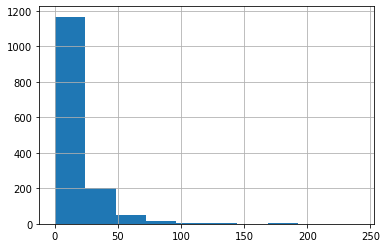

In [13]:
books_dataset.likes.hist()

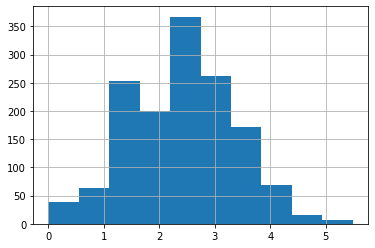

In [14]:
(books_dataset.likes.astype(float)+1).apply(np.log).hist()